In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [8]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [9]:
df['LogPassengers'] = np.log(df['Passengers'])
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]
df['DiffLogPassengers'] = df['LogPassengers'].diff()
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [10]:
# RNN
i = Input(shape=(T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)
model = Model(i, x)


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2521 (9.85 KB)
Trainable params: 2521 (9.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [13]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 [==============================] - 1s 44ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 11/100
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 85/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 86/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 87/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 88/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 89/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 90/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 91/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 92/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 93/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 94/100
4/4 [===============

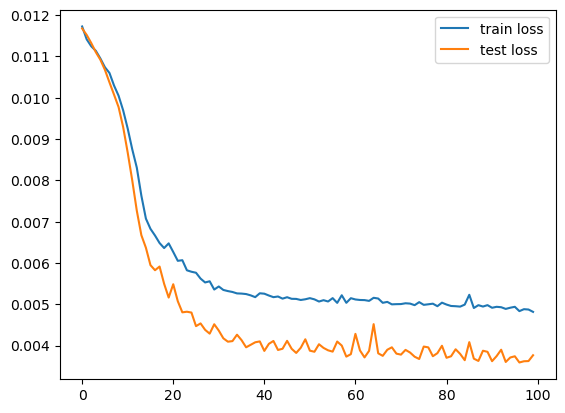

In [14]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [15]:
train_idx[:T+1] = False # first T+1 values are not predictable


In [16]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()


1/1 [==============================] - 0s 6ms/step


In [17]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']
# 1-step forecast


In [18]:
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest


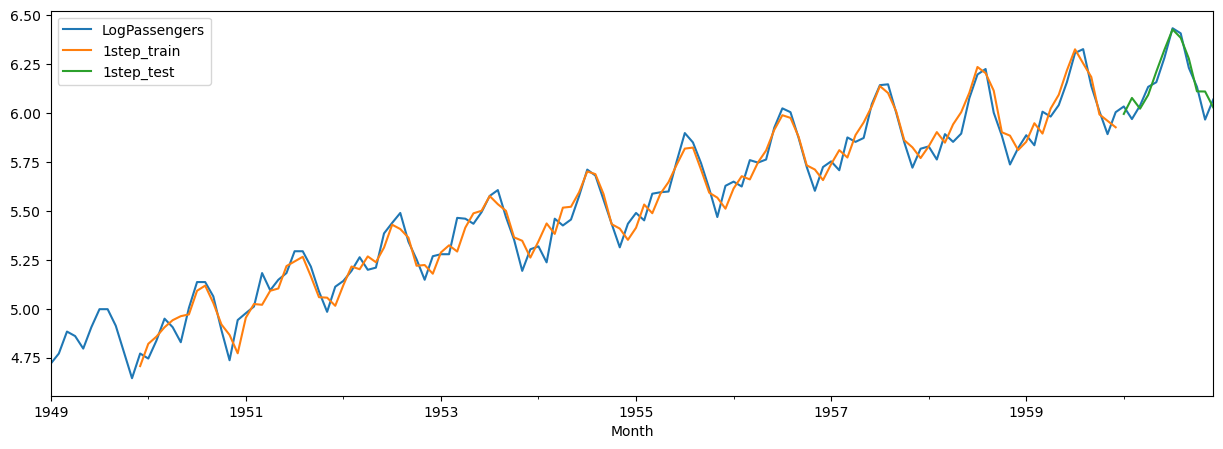

In [19]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [20]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 6ms/step


In [21]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

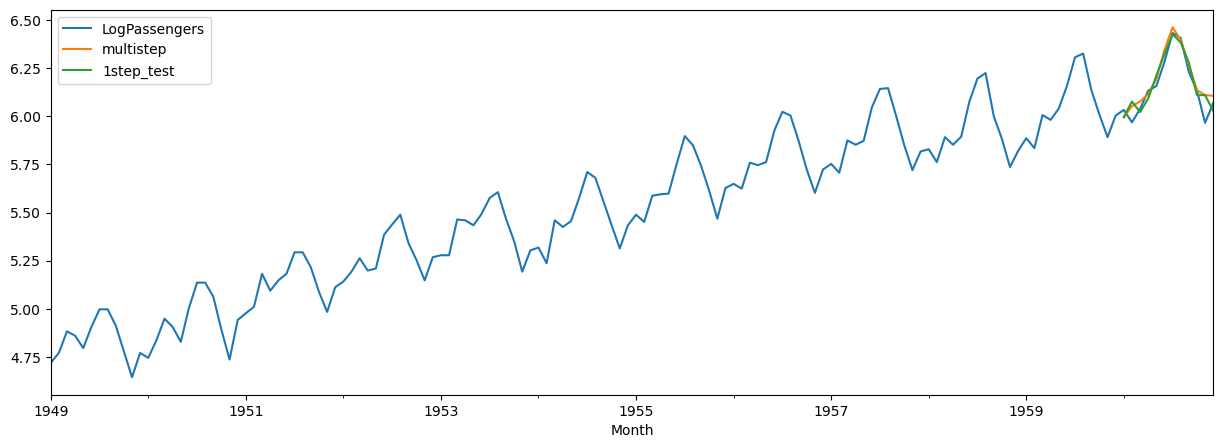

In [22]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [23]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [24]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [25]:
# RNN
i = Input(shape=(Tx, 1))
x = LSTM(24, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [26]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)

In [27]:
model.compile(
  loss='mse',
  optimizer='adam',
)
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300
4/4 [==============================] - 1s 47ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 2/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 3/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 4/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 5/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 6/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 7/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 8/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 9/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 10/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 11/300
4/4 [==========

/Users/stefanduprey/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 13/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 14/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 15/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0107
Epoch 16/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 17/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 18/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 19/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 20/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 21/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 22/300
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 96/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 97/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 98/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 99/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 100/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 101/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 102/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 103/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 104/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 105/300
4/4 [=========

Epoch 178/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 179/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 180/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 181/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 182/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 183/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 184/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 185/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 186/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 187/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 188/

4/4 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 261/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 262/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 263/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 264/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 265/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 266/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 267/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 268/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 269/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 270/300
4/4 [=====

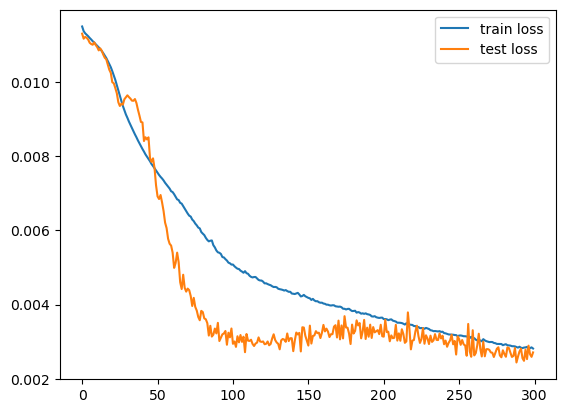

In [28]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [29]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')


In [30]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 6ms/step


In [31]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [32]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [33]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)


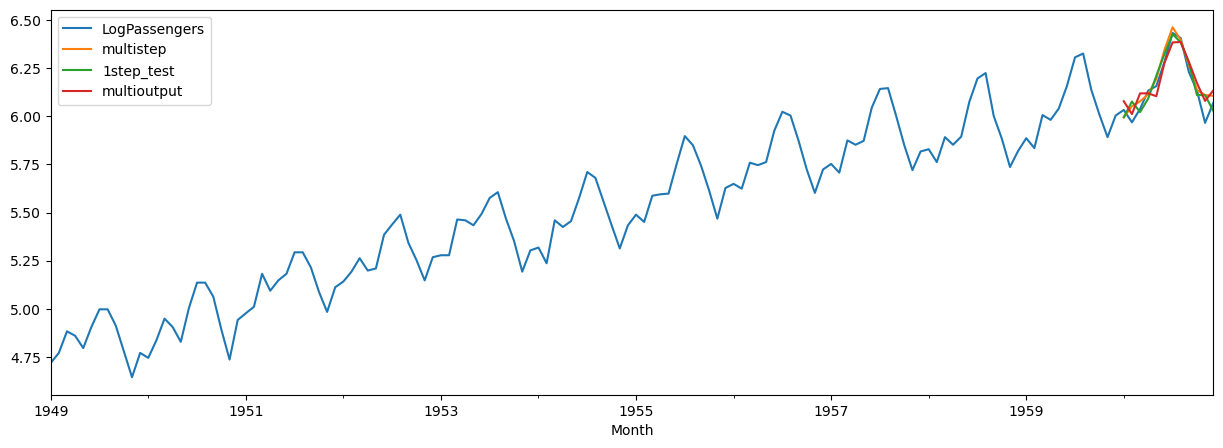

In [34]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [35]:
# RNN multiple LSTM layers
i = Input(shape=(Tx, 1))
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)
model.compile(
  loss='mse',
  optimizer='adam',
)
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300
4/4 [==============================] - 1s 73ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 2/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 3/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 4/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 5/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 6/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 7/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 8/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 9/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 10/300
1/4 [======>.......................] - ETA: 0s - loss: 0.0110

/Users/stefanduprey/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 11/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 12/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 13/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 14/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0100
Epoch 15/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0097
Epoch 16/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0095
Epoch 17/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 18/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0089
Epoch 19/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0085
Epoch 20/300
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 94/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 95/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 96/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 97/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 98/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 99/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 100/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 101/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 102/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 103/300
4/4 [===========

Epoch 176/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 177/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 178/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 179/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 180/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 181/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 182/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 183/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 184/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 185/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 186/

4/4 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 259/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 260/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 261/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 262/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 263/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 264/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 265/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 266/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 267/300
4/4 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 268/300
4/4 [=====

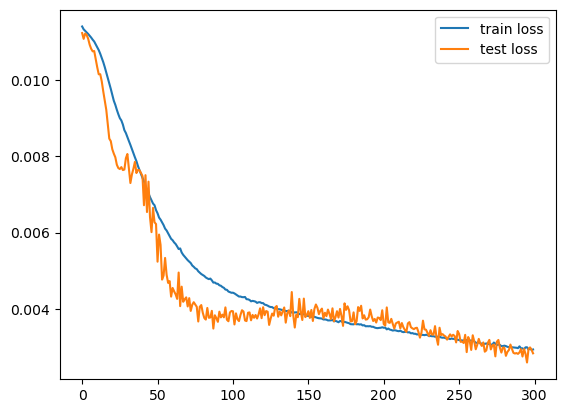

In [37]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

1/1 [==============================] - 0s 6ms/step


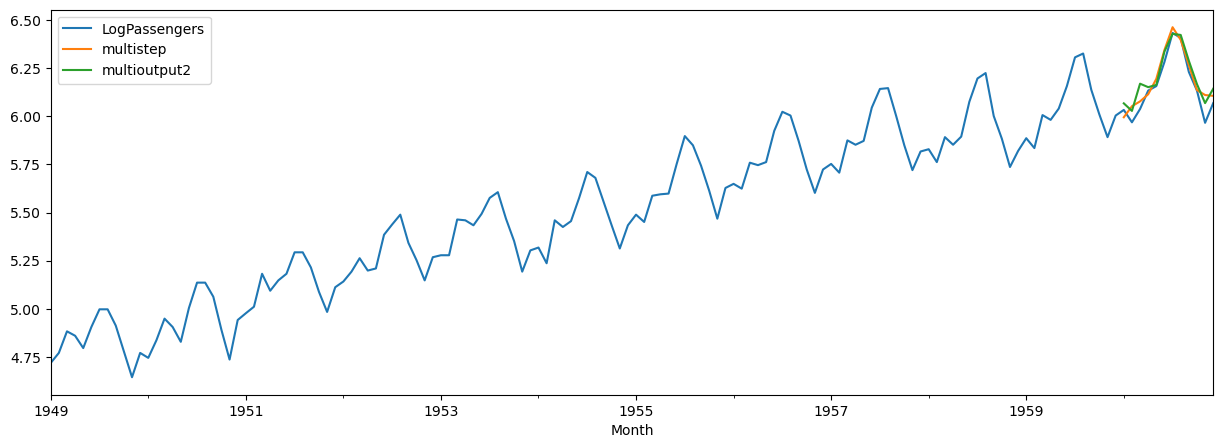

In [36]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput2'] = last_train + \
  np.cumsum(Ptest)
# plot all forecasts
cols = ['LogPassengers', 'multistep', 'multioutput2']
df[cols].plot(figsize=(15, 5));

In [38]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output (2 LSTMs) MAPE:", mape3)

multi-step MAPE: 0.007410055691081211
multi-output MAPE: 0.007952648237359927
multi-output (2 LSTMs) MAPE: 0.008109027652227175


In [39]:
# Exercise:
# Is the improvement due to global max pooling? Or due to multiple LSTMs layers?
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?